In [1]:
import time
import numpy as np
import pandas as pd
import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep

import pickle as pkl
import sys
sys.path.insert(0,'..')
from particlenet import ParticleNet
import torch
import torch.nn as nn
from torch_geometric.loader import DataListLoader, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline

import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

## TEST TRAINING

In [2]:
! ls ./ParticleNet_model

best_epoch.json        hyperparameters.json   model_kwargs.pkl
best_epoch_weights.pth loss_2_train.pkl       training_plots
epoch_0_weights.pth    loss_2_valid.pkl


In [3]:
test_data = torch.load("../data/toptagging/test/processed/data_0.pt")
loader = DataLoader(test_data, batch_size=4, shuffle=True)

In [4]:
# load the trained model
device = 'cpu'
PATH = "ParticleNet_model"
with open(f"{PATH}/model_kwargs.pkl", "rb") as f:
    model_kwargs = pkl.load(f)

state_dict = torch.load(f"{PATH}/best_epoch_weights.pth", map_location=device)

model = ParticleNet(**model_kwargs)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
sig = nn.Sigmoid()

y_score = None
y_test = None
for i, batch in enumerate(loader):
    preds, _, _, _ = model(batch)
    preds = sig(preds).detach()
    
    if y_score == None:
        y_score = preds[:].reshape(-1)
        y_test = batch.y
    else:
        y_score = torch.cat([y_score, preds[:].reshape(-1)])
        y_test = torch.cat([y_test, batch.y]) 
        
    if i==10000:
        break

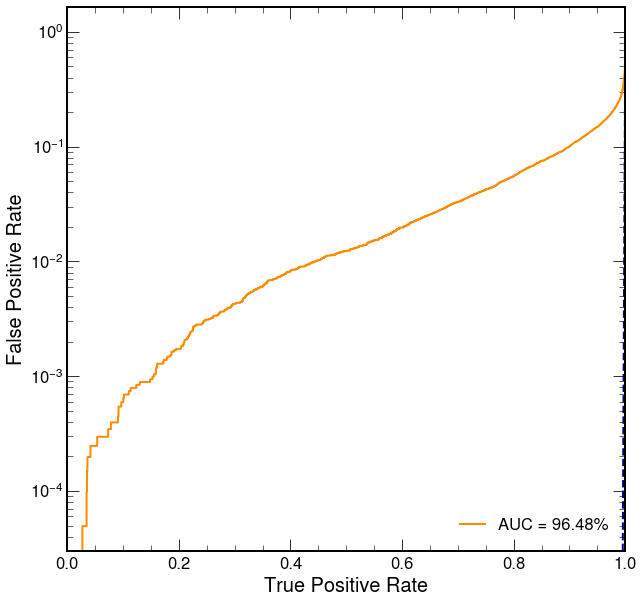

<Figure size 720x720 with 0 Axes>

In [20]:
# Compute ROC curve and ROC area for each class    
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
ax.plot(
    tpr,
    fpr,
    color="darkorange",
    lw=2,
    label=f"AUC = {round(auc(fpr, tpr)*100,2)}%",
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.yscale('log')
# plt.title("")
plt.legend(loc="lower right")
plt.show()
plt.savefig('Roc_curve.pdf');

## TEST LRP

In [2]:
import networkx as nx
import torch
import torch_geometric
import numpy as np
import pickle as pkl

with open('batch_x.pkl', 'rb') as handle:
    batch_x_list = pkl.load(handle)
with open('batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
with open('Rscores.pkl', 'rb') as handle:
    Rscores_list = pkl.load(handle)
with open('R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open('edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)

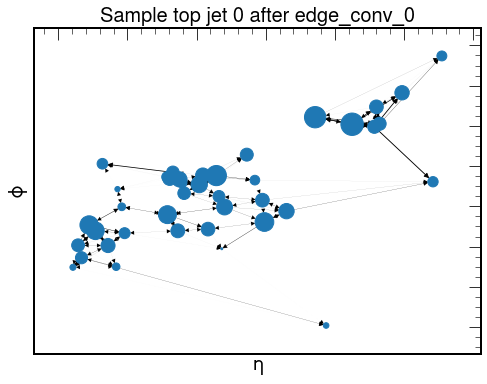

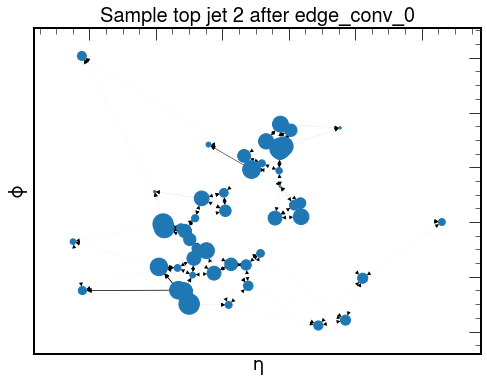

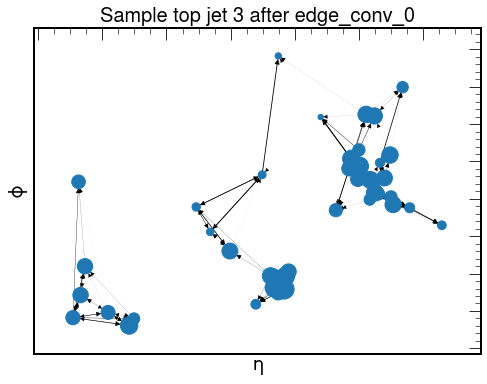

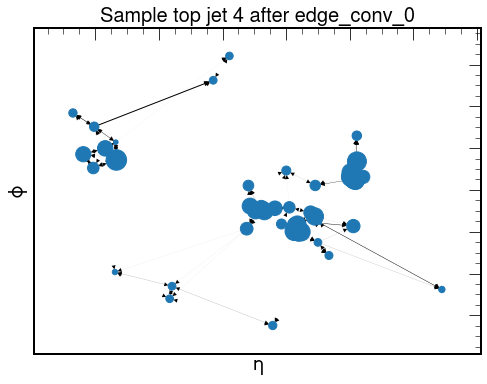

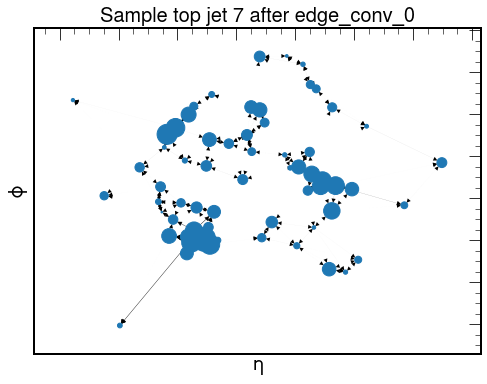

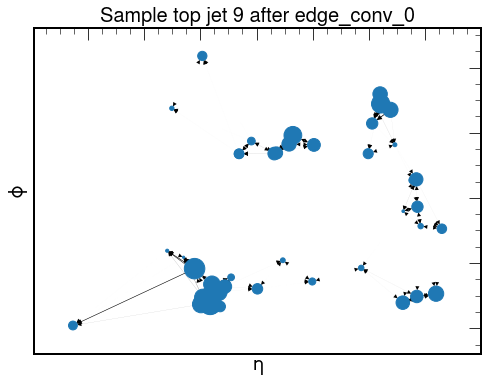

In [16]:
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html

### Edge features Rscores
score = 0 # qcd
score = 1 # top

for i in range(10):
    batch_y = batch_y_list[i]
    if batch_y==score:
        batch_x = batch_x_list[i]
        Rscores = Rscores_list[i]
        R_edges = R_edges_list[i]
        edge_index_dic = edge_index_list[i]

        if batch_y==1:
            sample = 'top'
        else:
            sample = 'qcd'

        num_nodes = len(Rscores)

        # Get positions of nodes in the graph
        # recall: Features, in order: [eta, phi, pt, mask].
        eta = batch_x[:, 0]
        phi = batch_x[:, 1]
        pt = np.abs(batch_x[:, 2])

        eta_phi = batch_x[:, :2]

        pos = {}
        for node_i in range(num_nodes):
            pos[node_i] = eta_phi.numpy()[node_i]

        # build graph
        to_undirected = False
        # for edgeconv in ['edge_conv_0', 'edge_conv_1', 'edge_conv_2']:
        for edgeconv in ['edge_conv_0']:    
            # if directed
            if to_undirected == False:
                edge_index, edge_weight = edge_index_dic[edgeconv], torch.abs(R_edges[edgeconv]).sum(axis=1)

            # if undirected
            else:
                edge_index, edge_weight = torch_geometric.utils.to_undirected(edge_index_dic[edgeconv], torch.abs(R_edges[edgeconv]).sum(axis=1))

            data = torch_geometric.data.Data(edge_index=edge_index, edge_weight=edge_weight, num_nodes=num_nodes)
            G = torch_geometric.utils.to_networkx(data, to_undirected=to_undirected)

            fig, ax = plt.subplots(figsize=(8, 6))
            nx.draw_networkx(G, pos, node_size=100*pt, with_labels=False, width=edge_weight/edge_weight.max(), ax=ax)   
            ax.set_xlabel(r"$\eta$", fontsize=20)
            ax.set_ylabel(r"$\phi$", fontsize=20);
            ax.set_title(f'Sample {sample} jet {i} after {edgeconv}', fontsize=20);
    #             plt.savefig(f'xai_plots/{edgeconv}.pdf')

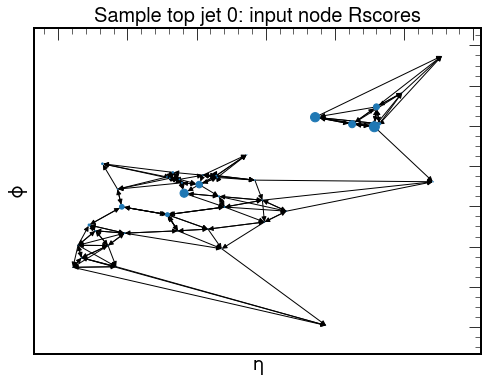

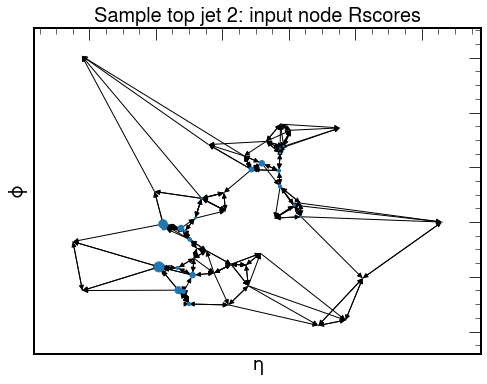

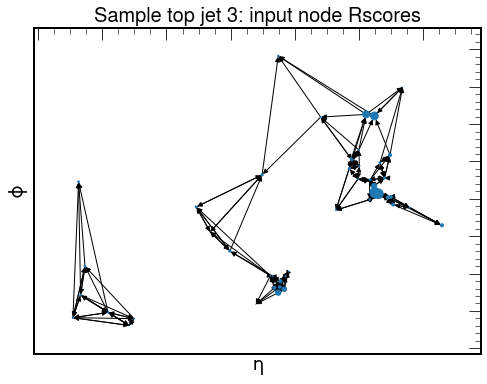

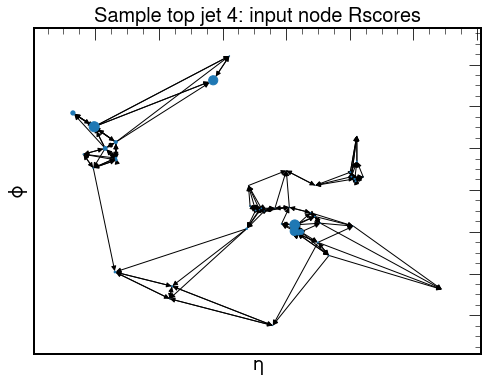

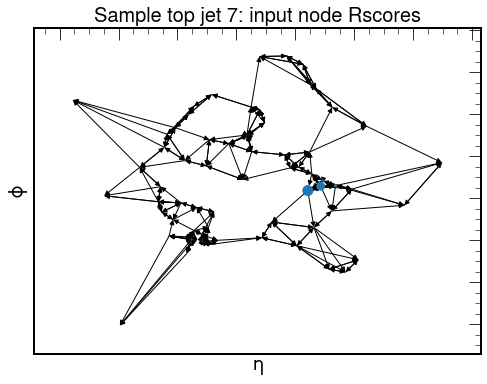

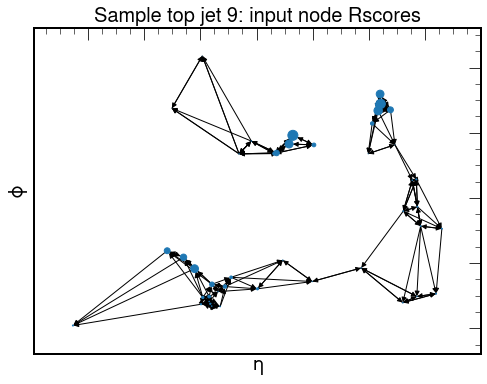

In [19]:
# https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html

### Input features Rscores
# score = 0 # qcd
score = 1 # top

for i in range(10):
    batch_y = batch_y_list[i]
    if batch_y==score:
        batch_x = batch_x_list[i]
        Rscores = Rscores_list[i]
        R_edges = R_edges_list[i]
        edge_index_dic = edge_index_list[i]

        if batch_y==1:
            sample = 'top'
        else:
            sample = 'qcd'
            
        num_nodes = len(Rscores)
        
        # Get positions of nodes in the graph
        # recall: Features, in order: [eta, phi, pt, mask].
        eta = batch_x[:, 0]
        phi = batch_x[:, 1]
        pt = np.abs(batch_x[:, 2])

        eta_phi = batch_x[:, :2]
        
        pos = {}
        for node_i in range(num_nodes):
            pos[node_i] = eta_phi.numpy()[node_i]

        # build graph
        to_undirected = False
        
        # if directed
        if to_undirected == False:
            edge_index = edge_index_dic['edge_conv_0']

        # if undirected
        else:
            edge_index = torch_geometric.utils.to_undirected(edge_index_dic['edge_conv_0'])

        data = torch_geometric.data.Data(edge_index=edge_index, num_nodes=num_nodes)
        G = torch_geometric.utils.to_networkx(data, to_undirected=to_undirected)

        try:
            fig, ax = plt.subplots(figsize=(8, 6))
            nx.draw_networkx(G, pos, node_size=100*torch.abs(Rscores).sum(axis=1)/torch.abs(Rscores).sum(axis=1).max(), with_labels=False, ax=ax)   
        except:
            continue

        ax.set_xlabel(r"$\eta$", fontsize=20)
        ax.set_ylabel(r"$\phi$", fontsize=20);
        ax.set_title(f'Sample {sample} jet {i}: input node Rscores', fontsize=20);